In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from scipy.stats import linregress
import random

%config InlineBackend.figure_format = 'retina'

**Figure 1 -- ECI(software, trade, technology, research) comparison**

In [2]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

R2 0.606 p-value 0.0    software - trade
R2 0.616 p-value 0.0    software - technology
R2 0.517 p-value 0.0    software - research


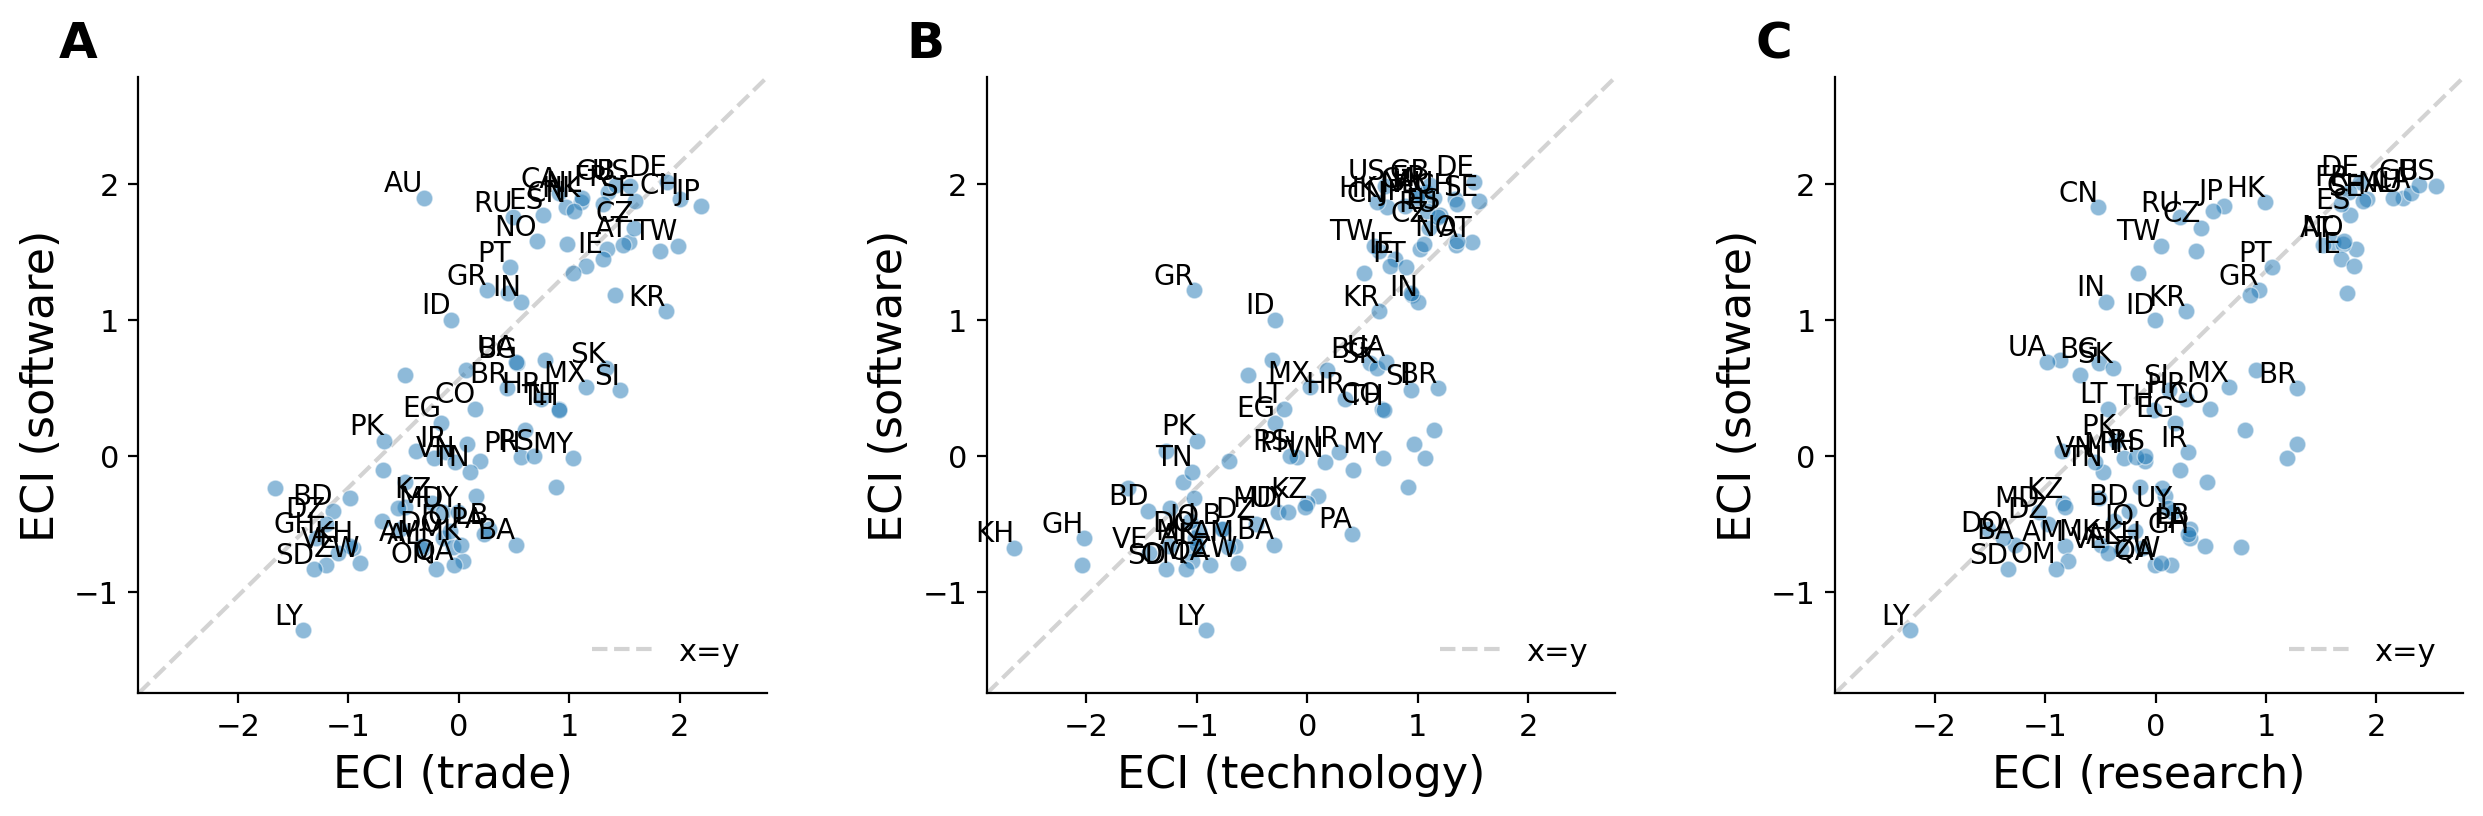

In [3]:
# ECI comparison
fig, ax = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.35)
fontsize = 16


# for axis setting
min_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].min().min() - 0.25
max_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].max().max() + 0.25


# A -- software vs trade
sns.scatterplot(x="trade_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[0])
#sns.regplot(x="trade_eci_2020", y="seci_2020", data=df2, scatter=False, ci=95, ax=ax[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2['trade_eci_2020'], df2['software_eci_2020'])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - trade")
#ax[0].annotate(f'R2: {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
ax[0].set_xlabel("ECI (trade)", size=fontsize)
ax[0].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[0].text(
            df2["trade_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# B -- software vs technology
sns.scatterplot(x="tech_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[1])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["tech_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - technology")
ax[1].set_xlabel("ECI (technology)", size=fontsize)
ax[1].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[1].text(
            df2["tech_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# C -- software vs research
sns.scatterplot(x="research_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["research_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - research")
ax[2].set_xlabel("ECI (research)", size=fontsize)
ax[2].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[2].text(
            df2["research_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 !=  0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# common axis settings
for p in [0,1,2]:
    ax[p].tick_params("x", labelsize=(fontsize-5))
    ax[p].tick_params("y", labelsize=(fontsize-5))
    ax[p].spines['top'].set_visible(False)
    ax[p].spines['right'].set_visible(False)
    ax[p].set_xlim(min_value, max_value)
    ax[p].set_ylim(-1.75, max_value)
    ax[p].plot(ax[p].get_xlim(), ax[p].get_ylim(), ls="--", c="lightgrey", label="x=y", zorder=0)
    ax[p].legend(loc="lower right", frameon=False, prop={'size': fontsize-5},)


# subplot title
for a, label in zip(ax, ['A','B','C','D']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,20), textcoords='offset pixels', weight='bold', size=fontsize+2)


# save
plt.savefig(f"../figures/fig01_eci_comparison.png", dpi=300, bbox_inches="tight", facecolor="white")

**Figure 2 -- language space**

In [4]:
# language space from code/01_data_prep_complexity.ipynb
el = pd.read_csv("../outputs/software_space_edgelist_2020_2021_based.csv", sep=";")
cdf = pd.read_csv("../outputs/software_complexity_2020_2021_based.csv", sep=";")

In [5]:
posh_list = [
    "Stata",
    "Julia",
    #"Mathematica",
    "GAP",
    "Elm",
    "OCaml",
    "VBA",
    "Fortran",
    "Cuda",
    "Pascal",
    "sed",
    "Perl",
    "awk",
    #"MATLAB",
    "R",
    "C",
    "C++",
    "Python",
    "Java",
    "Typescript",
    "HTML",
    #"CSS",
    "C#",
    "Swift",
    "Kotlin",
    "UnrealScript",
    "Lisp",
    "LLVM",
    #"Brainfuck",
    "CoffeeScript",
    "Prolog",
    #"F#",
    "Scheme",
    #"PowerShell",
    "Jupyter Notebook",
    "Racket",
    #"Game Maker Language",
    "HyPhy",
    "OpenSCAD",
    "Bicep"
]

In [6]:
def software_space_of_country(el, complexity_table, country_code):
    # focal country
    ctable = complexity_table[complexity_table["iso2_code"]==country_code]
    
    # RCA filter
    ctable = ctable[ctable["rca"] >= 1]

    cel = pd.merge(
        el,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_1",
        right_on="language",
        how="left"
    )
    cel = pd.merge(
        cel,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_2",
        right_on="language",
        how="left",
        suffixes=["_i", "_j"]
    )

    # filter cel
    cel = cel.dropna(subset=["rca_i", "rca_j"])
    
    # clean up
    cel = cel[["language_1", "language_2", "proximity"]]

    return cel

In [7]:
# common setting
selected_seed=565

def custom_graphviz_layout(G, seed=None, **kwargs):
    """graphviz layout does not have a built in seed otion"""
    # set the random seed if provided
    if seed is not None:
        random.seed(seed)
    # call the original graphviz_layout function with any additional kwargs
    return nx.drawing.nx_agraph.graphviz_layout(G, **kwargs)

#pos = nx.drawing.nx_agraph.graphviz_layout(ss_graph, prog='neato')
ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
pos = custom_graphviz_layout(ss_graph, seed=selected_seed, prog='neato')

#pos = {key: (value[0]*0.85, value[1]) for key, value in pos.items()}

In [8]:
el1 = software_space_of_country(el, cdf, country_code="IN")
graph1 = nx.from_pandas_edgelist(el1, source="language_1", target="language_2")
el2 = software_space_of_country(el, cdf, country_code="US")
graph2 = nx.from_pandas_edgelist(el2, source="language_1", target="language_2")
el3 = software_space_of_country(el, cdf, country_code="RU")
graph3 = nx.from_pandas_edgelist(el3, source="language_1", target="language_2")

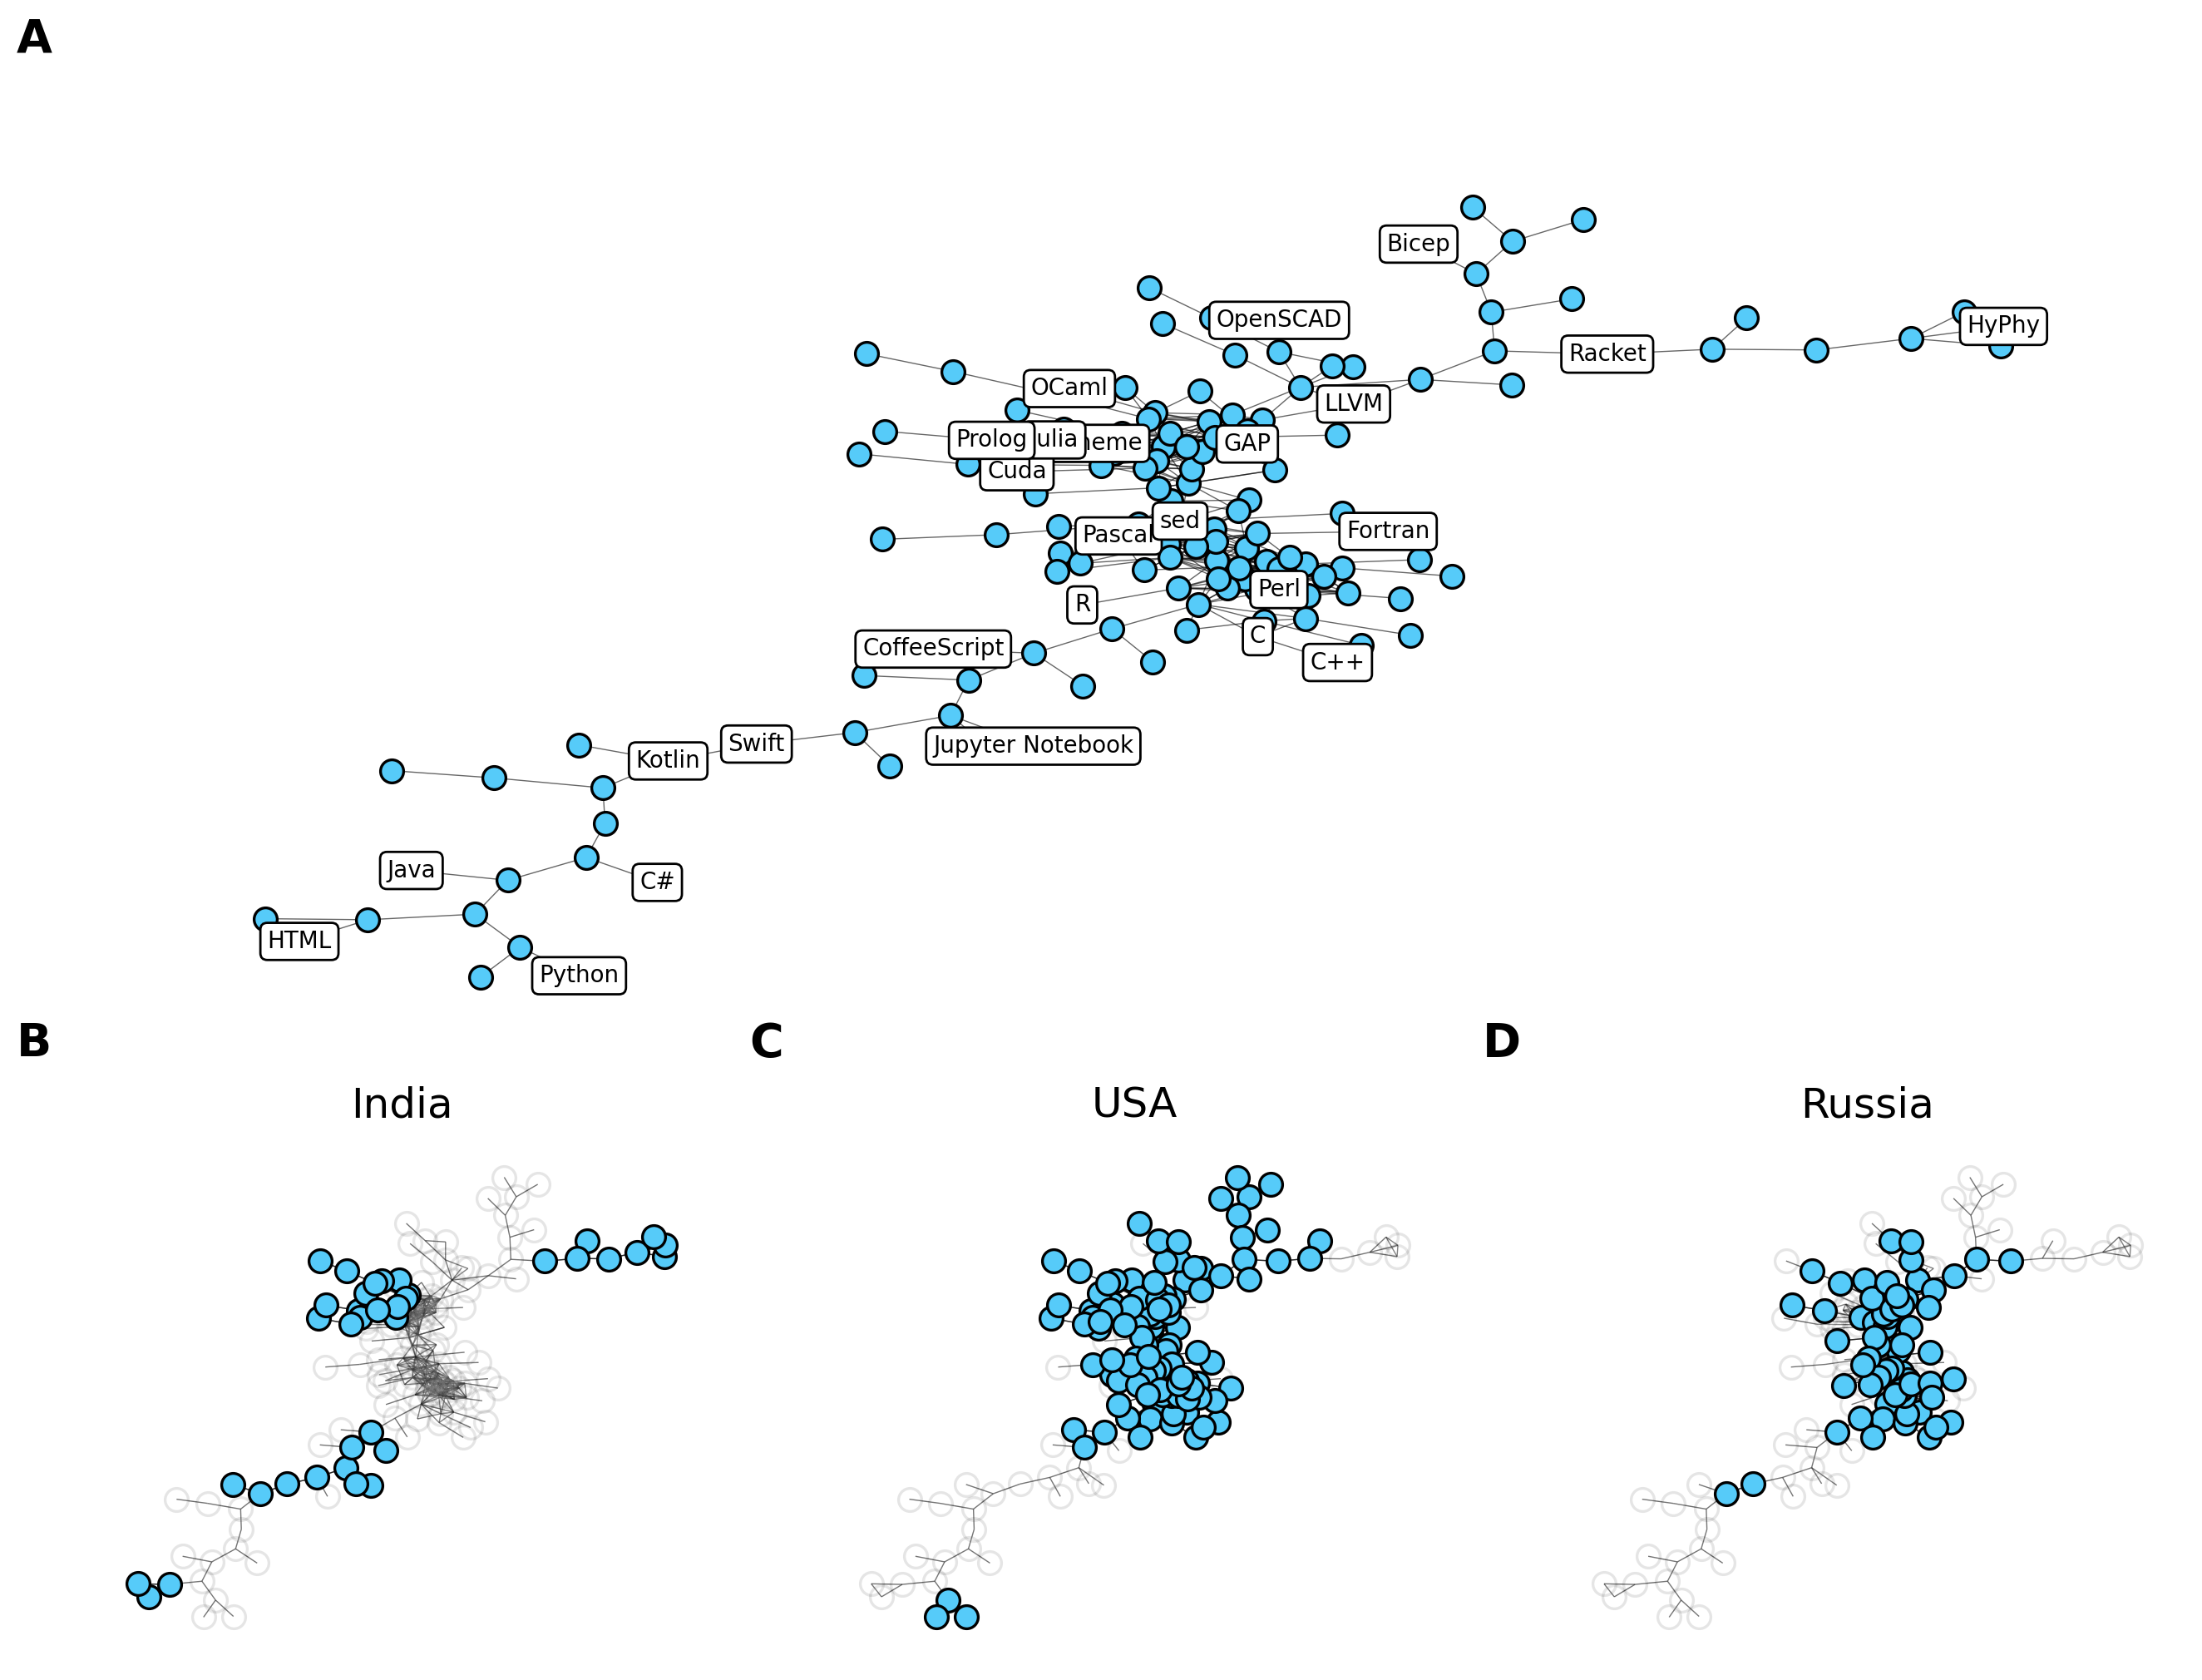

In [9]:
fig = plt.figure(figsize=(22,12))

ax = [0]*8
gs = GridSpec(2,4, figure=fig, height_ratios=[1.75, 1])
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[1,0])
ax[2] = fig.add_subplot(gs[1,1])
ax[3] = fig.add_subplot(gs[1,2])
fig.subplots_adjust(hspace=0.1, wspace=0.15)

fontsize = 18

# A -- full graph
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color="black", width=.5, alpha=.6, ax=ax[0])
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color="#56CBF9", linewidths=1.2, edgecolors='black', ax=ax[0])
nx.draw_networkx_labels(ss_graph.subgraph(posh_list), bbox = dict(facecolor = "white", boxstyle="round"), pos=pos, font_size=fontsize-8, ax=ax[0])
ax[0].axis('off')

# B -- graph1
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_edges(graph1, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
#nx.draw_networkx_nodes(hu_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_nodes(graph1, pos, node_size=100, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[1]) # alpha=.5
ax[1].axis('off')
ax[1].set_title("India", size=fontsize)

# C -- Sweden
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_edges(graph2, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
#nx.draw_networkx_nodes(se_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_nodes(graph2, pos, node_size=100, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[2]) # alpha=.5
ax[2].axis('off')
ax[2].set_title("USA", size=fontsize)

# D -- Serbia
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_edges(graph3, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
#nx.draw_networkx_nodes(rs_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_nodes(graph3, pos, node_size=100, node_color='#56CBF9', linewidths=1.2, edgecolors='black', ax=ax[3]) # alpha=.5
ax[3].axis('off')
ax[3].set_title("Russia", size=fontsize)

# subplot title
for a, label in zip(ax, ['A','B','C','D']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,90), textcoords='offset pixels', weight='bold', size=fontsize+2)

# save
plt.savefig(f"../figures/fig02_language_spaces.png", dpi=300, bbox_inches="tight", facecolor="white")

In [10]:
print(ss_graph.number_of_nodes(), " nodes")
print(ss_graph.number_of_edges(), " edges")

148  nodes
443  edges


(-99.34408, 1613.64808, -175.66200000000003, 2056.062)

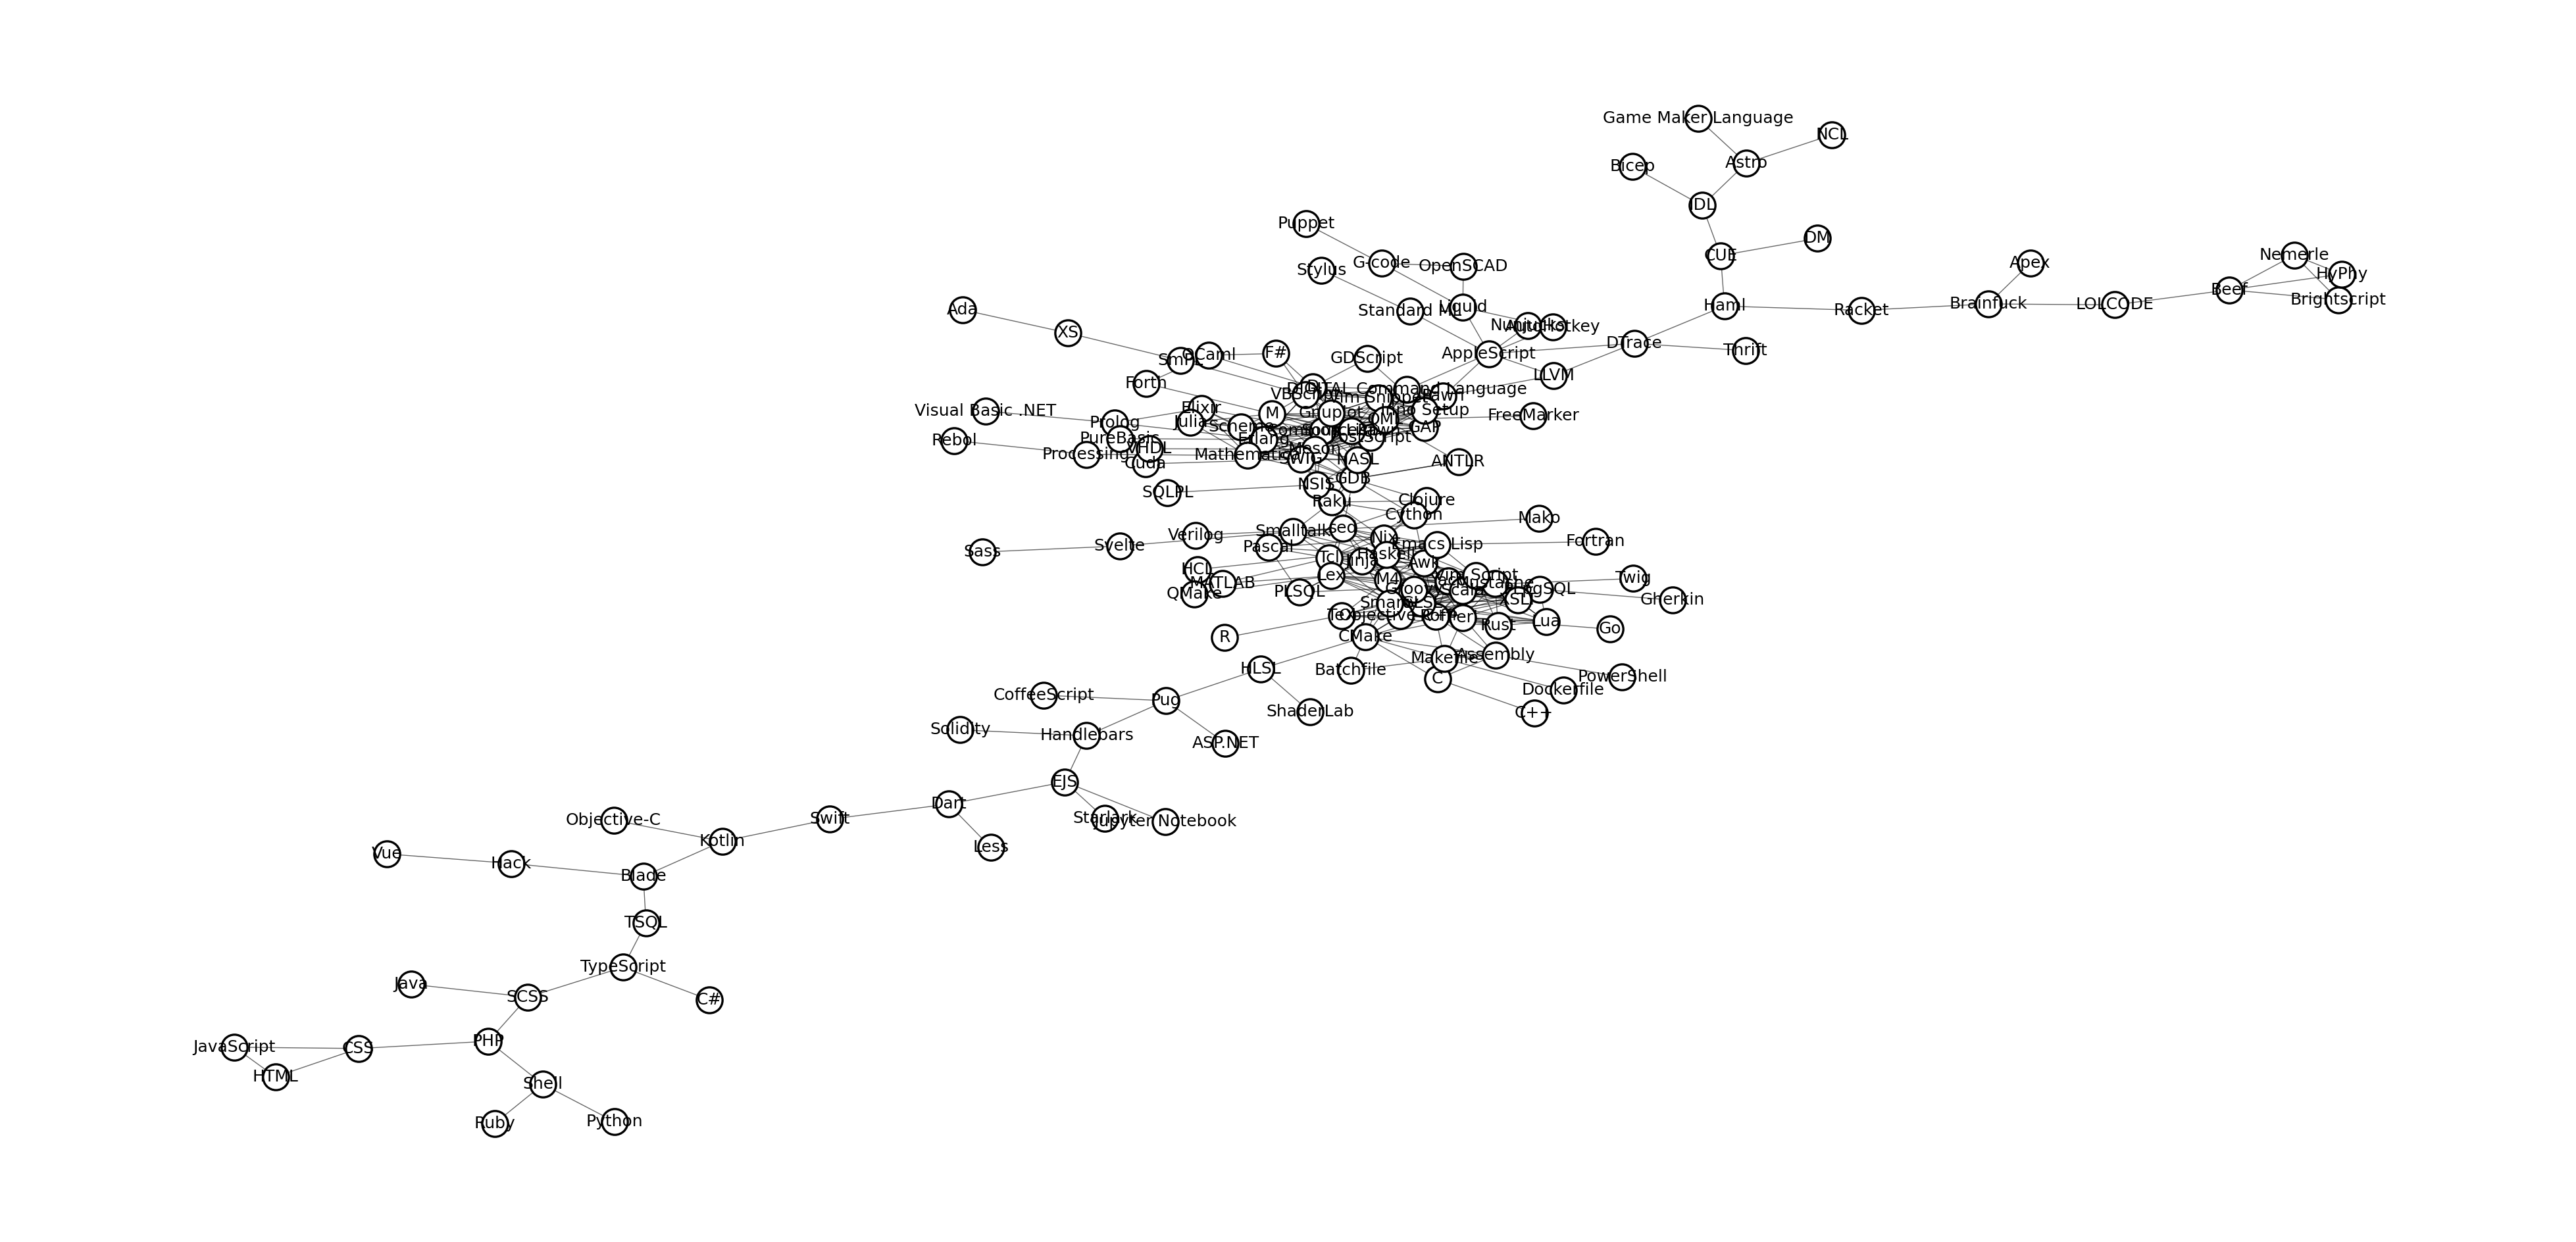

In [11]:
# full network plot
ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(25,12))
pos = nx.drawing.nx_agraph.graphviz_layout(ss_graph, prog='neato')

nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax)
#nx.draw_networkx_nodes(ss_graph, pos, node_size=250, node_color='white',linewidths=1.2, edgecolors='black', ax=ax) # alpha=.1,
nx.draw_networkx_nodes(ss_graph, pos, node_size=200, node_color='white',
#'#56CBF9',
linewidths=1.2, edgecolors='black', ax=ax) # alpha=.5,

nx.draw_networkx_labels(ss_graph,# bbox = dict(facecolor = "white",boxstyle='round'),
    pos=pos,font_size=9, ax=ax)
ax.axis('off')

In [12]:
cdf[["language", "pci"]].drop_duplicates().sort_values(by="pci").head(20)

,language,pci
52,HTML,-1.323931
19,CSS,-1.314623
61,JavaScript,-1.212258
30,Dart,-0.798440
90,PHP,-0.759285
111,Ruby,-0.749327
113,SCSS,-0.727485
60,Java,-0.608274
53,Hack,-0.600029
130,Swift,-0.578977
